In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

In [17]:
img = imread('ultrassound/cropped/503311001.bmp', as_gray=True)
mask = imread('ultrassound/masks/503311001.bmp')

In [5]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

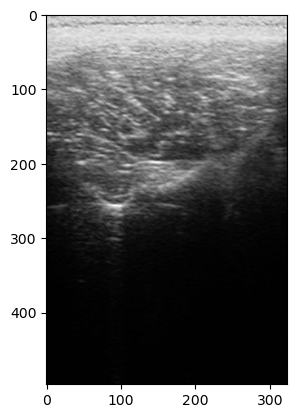

In [507]:
plt.imshow(img, cmap='gray')

## CARREGANDO BASE

In [28]:
from glob import glob
import os

def load_images(DATABASE_PATH, classes):
    database = []
    
    for classe in classes:

        IMAGES_NAME = glob(os.path.join(DATABASE_PATH, classe, '*.bmp'))
    
        imagens = []
        for IMAGE_NAME in IMAGES_NAME:
            imagens.append(imread(IMAGE_NAME, as_gray=True))
            
        database.append(imagens)
    
    return database

In [29]:
DATABASE_PATH = 'ultrassound/'

classes = ['cropped', 'masks']

database = load_images(DATABASE_PATH, classes)

In [30]:
img = database[0][0]

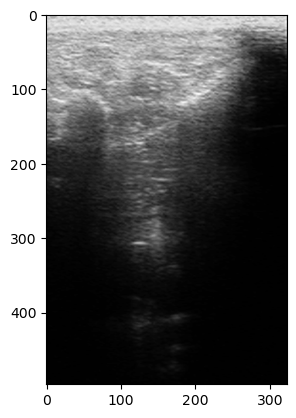

In [7]:
#For example to see the first image of the cropped images
plt.imshow(img, cmap='gray')

# Aplique o algoritmo K-means utilizando os pixels como pesos;

In [31]:
from sklearn.cluster import KMeans

In [32]:
# Apply many KMeans to see the results
def plot_KMeans(img, lmt):
    fig = plt.figure(figsize=(15, 15))
    
    for i in range(lmt[0],lmt[1]):
        fig.add_subplot(3, 3, i)
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(img.reshape(-1,1))
        cluster_assignment = kmeans.predict(img.reshape(-1,1))
        plt.title(f'KMeans for {i} clusters')
        plt.imshow(cluster_assignment.reshape(img.shape), cmap='gray')
    

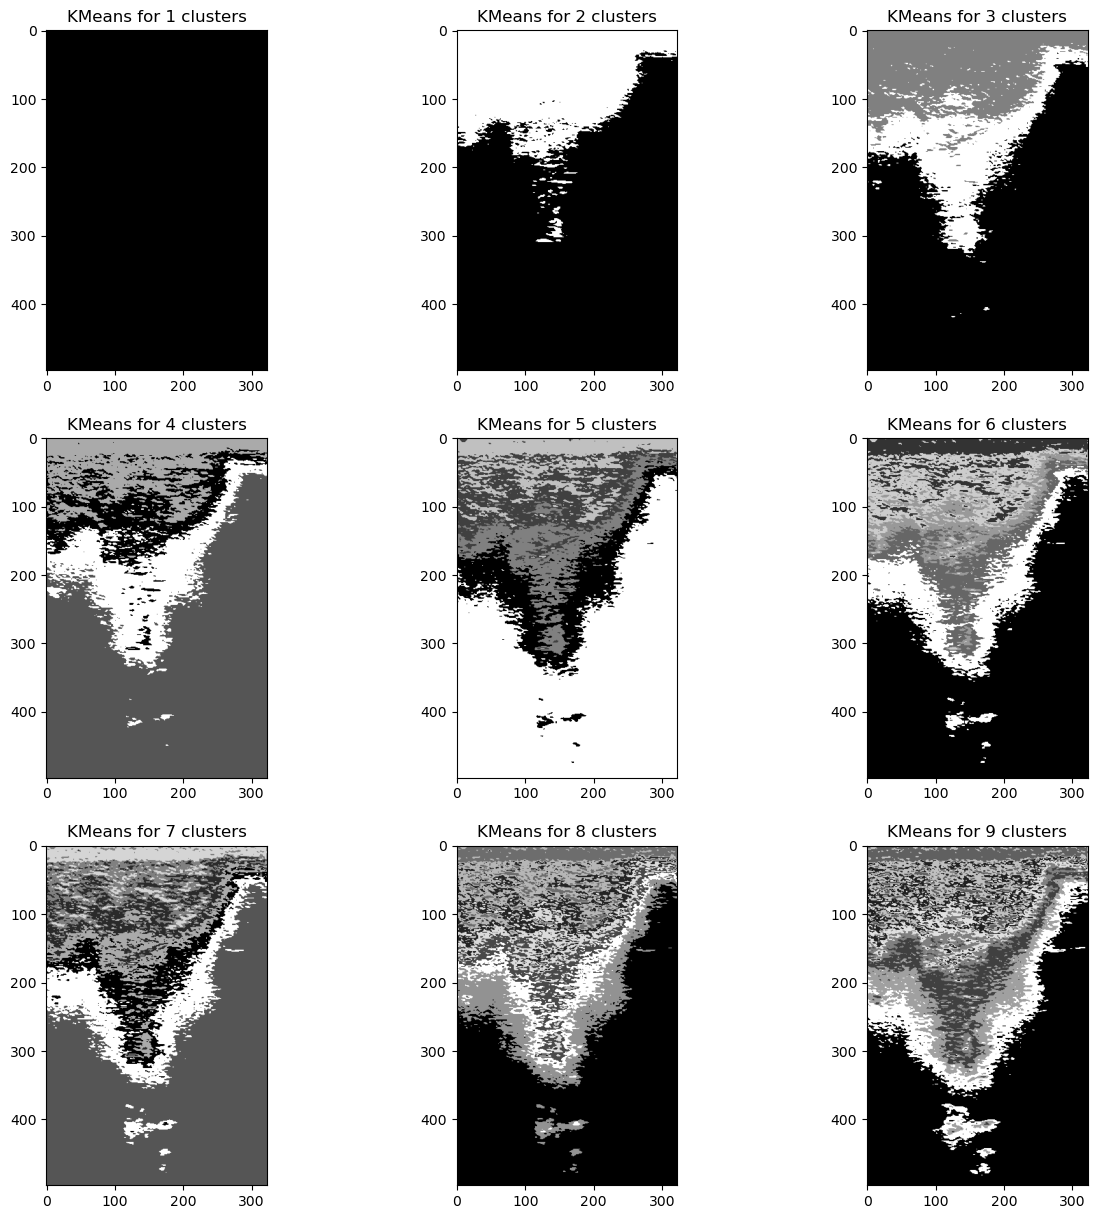

In [10]:
plot_KMeans(img, [1, 10])

O detalhamento do método de escolha do fore/background;

- O background é a parte de uma imagem que está atrás dos elementos principais e geralmente serve como um contexto para esses elementos. O foreground, por outro lado, é a parte da imagem que está na frente dos elementos principais. Como o observado nas mascaras feitas manualmente pelo especialista de domínio, o elemento que se deseja segmentar esta entre a camada mais clara a camada mais escura da imagem. Na função de seleção background e foreground são selecionados as camadas com menor (background) e maior (foreground) valores de centroide.

In [33]:
# max and min
def retorna_index_foreground_background(cluster_centers: np.ndarray)-> tuple:
    min_value = 99
    min_index = -1
    max_value = -1
    max_index = -1
    for index,cluster_center in enumerate(cluster_centers):
        if min_value > cluster_center:
            min_value = cluster_center
            min_index = index
        if max_value < cluster_center:
            max_value = cluster_center
            max_index = index
    return (min_index,max_index)

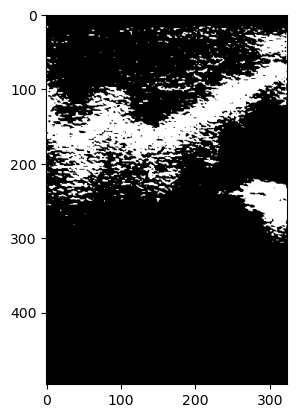

In [34]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(img.reshape(-1,1))
cluster_assignment = kmeans.predict(img.reshape(-1,1))
indices = retorna_index_foreground_background(kmeans.cluster_centers_)
cluster_assignment = (cluster_assignment != indices[0]) & (cluster_assignment != indices[1])
plt.imshow(cluster_assignment.reshape(img.shape), cmap='gray')

In [35]:
def make_kmeans(database, k):
    kmeans = KMeans(k)
    new_database = []
    for img in database[0]:
        kmeans.fit(img.reshape(-1,1))
        cluster_assignment = kmeans.predict(img.reshape(-1,1))
        indices = retorna_index_foreground_background(kmeans.cluster_centers_)
        cluster_assignment = (cluster_assignment != indices[0]) & (cluster_assignment != indices[1])
        new_database.append(cluster_assignment.reshape(img.shape))
    return new_database

In [36]:
kmeans_database = make_kmeans(database, 3)

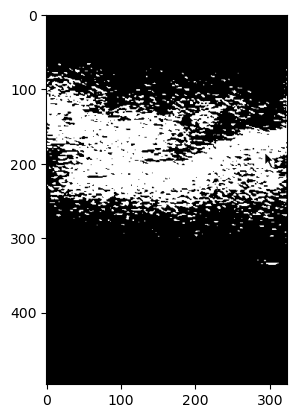

In [37]:
plt.imshow(kmeans_database[2], cmap='gray')

## Implemente duas segmentações utilizando os algoritmos de binarização local e global (Niblack e Otsu, respectivamente);

In [38]:
from skimage.filters import threshold_niblack, threshold_otsu
from functools import partial

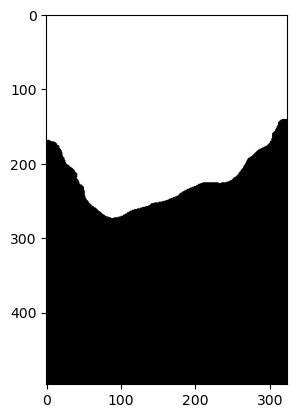

In [168]:
# Apply Niblack only for example
niblack = threshold_niblack(img, window_size=35, k=0.8)
niblack = niblack > 0.1
plt.imshow(niblack, cmap='gray')

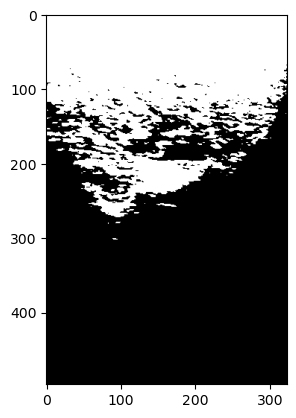

In [139]:
# Apply Otsu only for example
otsu = threshold_otsu(img)
otsu_img = img > otsu
plt.imshow(otsu_img, cmap='gray')

In [170]:
# Apply the thresholds to see the results
def make_thresholds_niblack(database, window_size, k):
    new_database = []
    for img in database[0]:
        niblack = threshold_niblack(img, window_size=window_size, k=k)
        new_database.append(niblack > 0.1)
    return new_database

In [171]:
def make_thresholds_otsu(database):
    new_database = []
    for img in database[0]:
        otsu = threshold_otsu(img)
        new_database.append(img > otsu)
    return new_database

In [173]:
niblack_database = make_thresholds_niblack(database, window_size=35, k=0.8)
otsu_database = make_thresholds_otsu(database)

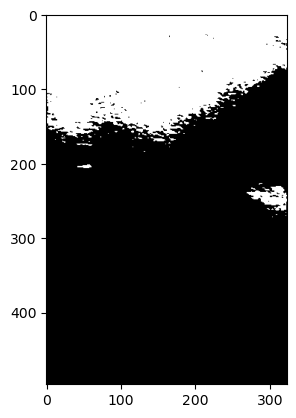

In [174]:
plt.imshow(otsu_database[0], cmap='gray')

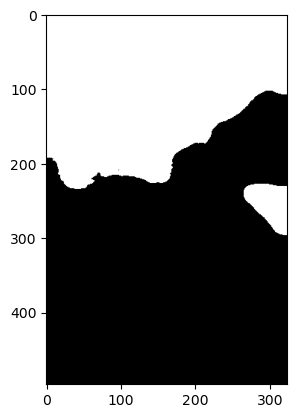

In [175]:
plt.imshow(niblack_database[0], cmap='gray')

# Aplique   outro   algoritmo   de   agrupamento   que   utilize   também   a   posição espacial dos pixels como peso;
* MeanShift é uma técnica de processamento de imagem e análise de dados que visa encontrar pontos de máxima densidade em um espaço de recursos. É frequentemente usado para agrupar dados, já que ele se move na direção da densidade de dados local até atingir um ponto de convergência. O resultado é um agrupamento de pontos de dados similares baseados na densidade local.

In [23]:
#obs estudar meanshift e seus parametros

In [44]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift, estimate_bandwidth
from matplotlib import pyplot as plt
from skimage.io import imread

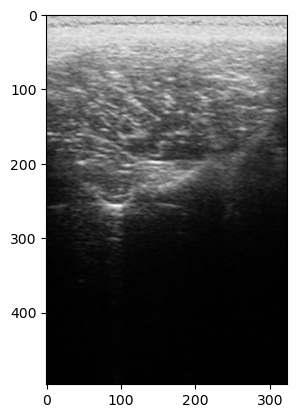

In [45]:
img = imread('ultrassound/cropped/503311001.bmp', as_gray=True)
plt.imshow(img, cmap='gray')

* quantile: é um valor entre 0 e 1 que determina o quantil usado para estimar a largura de banda. 
* n_samples: é o número de amostras usadas para estimar a largura de banda.
* bandwidth: é o valor da largura de banda usada para controlar a "suavidade" dos agrupamentos. Valores maiores resultam em agrupamentos mais suaves e menos precisos, enquanto valores menores resultam em agrupamentos mais precisos, mas também mais "ruidosos". 
* bin_seeding: é um booleano que indica se a inicialização dos centros dos agrupamentos deve ser baseada em amostras de histograma. 

Apenas testando com so uma imagem

In [46]:
bandwidth = estimate_bandwidth(img.reshape(-1, 1), quantile=0.4, n_samples=100)    
ms = MeanShift(bandwidth = bandwidth, bin_seeding=True)

In [47]:
ms.fit(img.reshape(-1, 1))
labels = ms.labels_
cluster_centers = ms.cluster_centers_

In [48]:
labels.shape
np.unique(labels)

array([0, 1, 2])

In [49]:
cluster_centers

array([[0.0219396 ],
       [0.2030423 ],
       [0.43908386]])

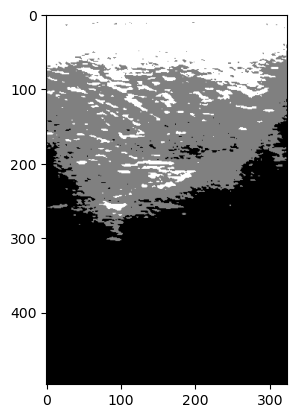

In [50]:
plt.imshow(labels.reshape(img.shape), cmap='gray')

In [51]:
type(labels)

numpy.ndarray

In [52]:
img_changed = labels
img_changed[labels == 2] = 0

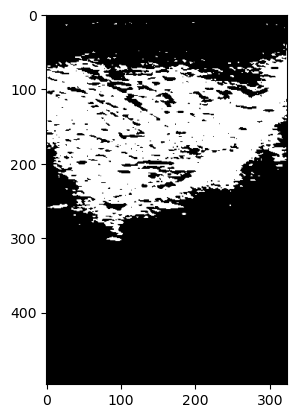

In [53]:
plt.imshow(img_changed.reshape(img.shape), cmap='gray')

Função que aplica na base inteira

In [57]:
def make_meanshift(database):
    new_database = []
    for img in database[0]:
        bandwidth = estimate_bandwidth(img.reshape(-1, 1), quantile=0.4, n_samples=100)    
        ms = MeanShift(bandwidth = bandwidth, bin_seeding=True, n_jobs = -1)
        ms.fit(img.reshape(-1, 1))
        labels = ms.labels_
        labels[labels == 2] = 0
        new_database.append(labels.reshape(img.shape))
    return new_database

In [58]:
meanshift_database = make_meanshift(database)

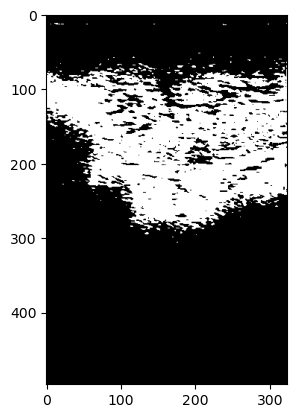

In [62]:
plt.imshow(meanshift_database[4], cmap='gray')

Pesquise em artigos do estado da arte métricas de acurácia de segmentação. Aplique
pelo menos duas métricas nos resultados de segmentação obtidos. Para isso, utilizem
as imagens na pasta “masks” que estão na base.

- SILVA, Lucas M. et al. Segmentação e contagem automática de ovos do Aedes Aegypti em palhetas de ovitrampa baseada em aprendizado profundo. Revista de Sistemas e Computação-RSC, v. 12, n. 1, 2022.

- REIST, Francisco Jose Dos Santos et al. BacillusNet: An automated approach using RetinaNet for segmentation of pulmonary Tuberculosis bacillus. In: 2021 IEEE Symposium on Computers and Communications (ISCC). IEEE, 2021. p. 1-4.

$$ \text{Accuracy} = \frac{\text{number of correct predictions}}{\text{total number of predictions}}
$$




A acurácia é calculada dividindo o número de previsões corretas pelo número total de previsões. O resultado é um número entre 0 e 1, onde 1 indica uma acurácia perfeita (todas as previsões são corretas) e 0 indica uma acurácia completamente errada (todas as previsões são erradas).

$$
IoU = \frac{Area \ of \ Intersection}{Area \ of \ Union} = \frac{True \ Positives}{True \ Positives + False \ Positives + False \ Negatives}
$$

Os parâmetros da fórmula são:

* True Positives (verdadeiros positivos): representa o número de pixels que foram corretamente identificados como fazendo parte de uma região de interesse.

* False Positives (falsos positivos): representa o número de pixels que foram incorretamente identificados como fazendo parte de uma região de interesse.

* False Negatives (falsos negativos): representa o número de pixels que deveriam ter sido identificados como fazendo parte de uma região de interesse, mas foram ignorados pelo modelo.

O resultado da métrica IoU é um número entre 0 e 1, onde 1 indica uma correspondência perfeita entre a máscara real e a máscara prevista pelo modelo, e 0 indica que não há correspondência entre as máscaras.

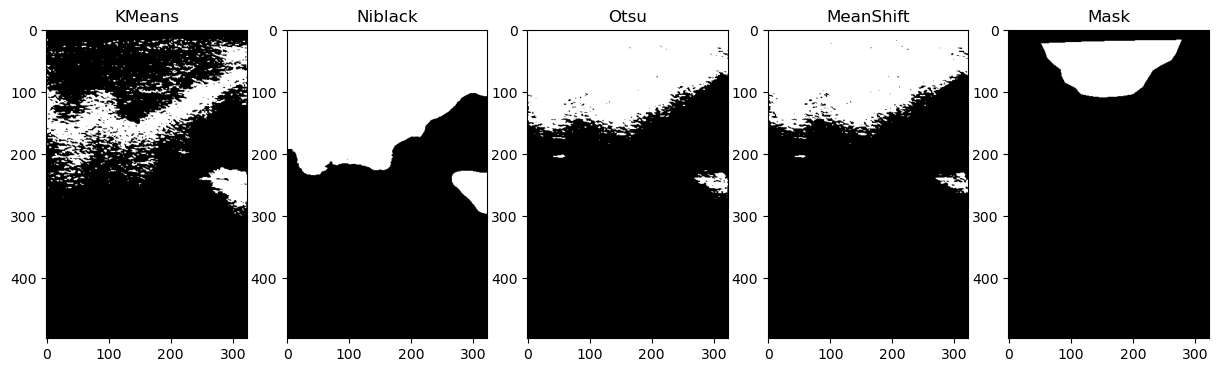

In [177]:
plot = plt.figure(figsize=(15, 15))
plot.add_subplot(1, 5, 1)
plt.imshow(kmeans_database[0], cmap='gray')
plt.title('KMeans')
plot.add_subplot(1, 5, 2)
plt.imshow(niblack_database[0], cmap='gray')
plt.title('Niblack')
plot.add_subplot(1, 5, 3)
plt.imshow(otsu_database[0], cmap='gray')
plt.title('Otsu')
plot.add_subplot(1, 5, 4)
plt.imshow(meanshift_database[0], cmap='gray')
plt.title('MeanShift')
plot.add_subplot(1, 5, 5)
plt.imshow(database[1][0], cmap='gray')
plt.title('Mask');

In [119]:
from sklearn.metrics import accuracy_score, confusion_matrix

def iou(y_true, y_pred):   
  cm = confusion_matrix(y_true.ravel(), y_pred.ravel())
  tn, fp, fn, tp = cm.ravel()

  iou = ((1.0 * tp) +1) / ((tp + fp + fn) +1)
  
  return iou

In [120]:
metrics = {'Accuracy': accuracy_score, 'IoU': iou}

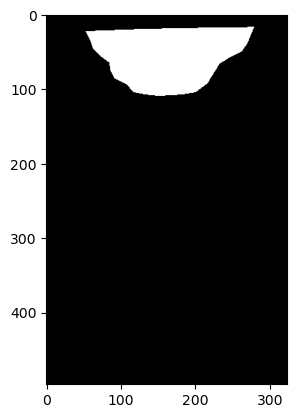

In [69]:
plt.imshow(database[1][0], cmap='gray')

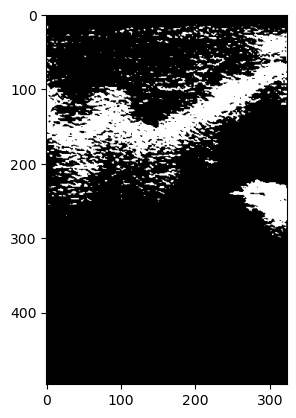

In [70]:
plt.imshow(kmeans_database[0], cmap='gray')

In [102]:
def to_bool(img):
    return img > 0

Exibindo o nivel de similaridade entre os três melhores

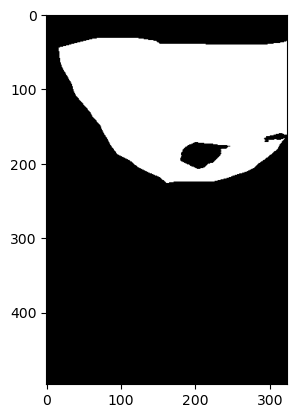

In [182]:
img_niblack = niblack_database[4].copy()
img_niblack[img_niblack != to_bool(database[1][4])] = 0
img_otsu = otsu_database[4].copy()
img_otsu[img_otsu != to_bool(database[1][4])] = 0
img_meanshift = meanshift_database[4].copy()
img_meanshift[to_bool(img_meanshift) != to_bool(database[1][4])] = 0
plt.imshow(img_niblack, cmap='gray')

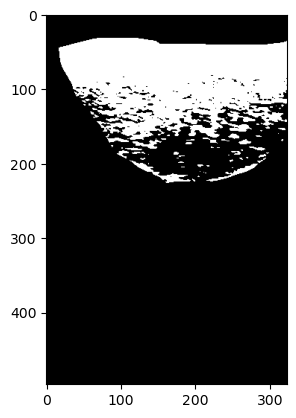

In [183]:
plt.imshow(img_otsu, cmap='gray')

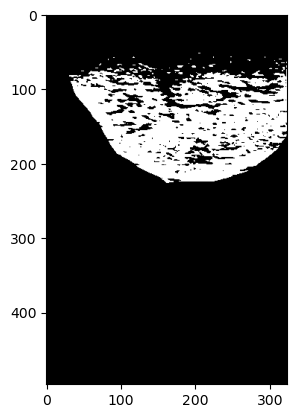

In [135]:
plt.imshow(img_meanshift, cmap='gray')

In [129]:
print(metrics['IoU'](to_bool(database[1][4]).reshape(-1, 1), to_bool(meanshift_database[4]).reshape(-1, 1)))

0.4168520008202022


In [113]:
# Apply the metrics in database to see the results
def make_metrics(database, masks, metrics):
    accs = 0
    results = []
    for metric in metrics:
        for img, mask in zip(database, masks):
            accs += metrics[metric](to_bool(mask).reshape(-1,1), to_bool(img).reshape(-1,1))
        results.append(accs/len(database))
        accs = 0
    return results

In [97]:
#Only testing in one database the metrics to see the results
print(make_metrics(kmeans_database, database[1], metrics))

[0.6963160428802638, 0.5395692139699602]


In [178]:
# Apply the metrics in all databases to see the results
def apply_metrics(databases, masks, metrics):
    results = {}
    for database in databases:
        results[database] = make_metrics(databases[database], masks, metrics)
    return results

In [179]:
databases = {'kmeans': kmeans_database, 'niblack': niblack_database, 'otsu': otsu_database, 'meanshift': meanshift_database}

In [180]:
result_all = apply_metrics(databases, database[1], metrics)

In [181]:
for i in result_all:
    print(f'Method: {i}: Accuracy: {result_all[i][0]} IoU: {result_all[i][1]}')

Method: kmeans: Acuracy: 0.7623586358694411 IoU: 0.2314174897422473
Method: niblack: Acuracy: 0.7182239488813004 IoU: 0.3772839873025426
Method: otsu: Acuracy: 0.8195010938515763 IoU: 0.42480158671146656
Method: meanshift: Acuracy: 0.8381132325831516 IoU: 0.39855035821926127


Uma conclusão explicando qual técnica foi melhor e o motivo.

O Otsu obteve resultados melhores em comparação ao Niblack devido à utilização de limiarização global, resultando em menor segmentação de partes e erros. Em comparação ao Meanshift, o Otsu apresenta vantagem pois segmenta a pele juntamente com a gordura. Em resumo, a técnica de limiarização global do Otsu é eficiente e resulta em melhor segmentação do que outros métodos.